# ICON Stencil -- Benchmark
This is the benchmark script
For the version that was used for the development see `Philip__ICON_velocity_advection_stencil_20.ipynb`.

In [1]:
import os, copy

UseGPU = True
if UseGPU:
    devType = 'GPU'
    os.environ['JAX_PLATFORMS'] = "cuda"
    os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".30"    # https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
    import cupy as np

else:
    devType = 'CPU'
    os.environ['JAX_PLATFORMS'] = "cpu"
    import numpy as np
#

from datetime import datetime
from pickle import dump

import numpy
import jax
import sys
import jax.numpy as jnp
from jax import jit, grad, vmap
from jax import random

# This must be enabled when `make_jaxpr` is called, because otherwhise we get problems.
jax.config.update("jax_enable_x64", True)

import dace
from dace.transformation.auto import auto_optimize as autoopt

if UseGPU:
    device = dace.DeviceType.GPU
    dace.config.Config.set("compiler", "cpu", "executable", value="/usr/bin/g++-12")
else:
    device = dace.DeviceType.CPU
#

In [2]:
from JaxprToSDFG import  JaxprToSDFG
t = JaxprToSDFG(device=device, inp_on_gpu=True)

In [3]:
noITIR = True   # Do not use the GT4Py based translators or results
noSDFG = False   # Do not use the JAX -> SDFG based translators.

In [4]:
_build_type = "Release"
# removing  -ffast-math from DaCe default compiler args in order to support isfinite/isinf/isnan built-ins
_cpu_args = dace.config.Config.get("compiler", "cpu", "args").replace('-ffast-math', '') + ' -fopenmp' + ' -faligned-new'

### Offset Providers
Here we define the offset providors, i.e. the connectivity.
It is important that they have to be read in a certain way.

In [5]:
from icondims import SimpleGridData

edge_to_cell_table = np.array(SimpleGridData.e2c_table).astype(np.int32)
cell_to_edge_table = np.array(SimpleGridData.c2e_table).astype(np.int32)
E2C2EO_table = np.array(SimpleGridData.e2c2eO_table).astype(np.int32)
E2V_table = np.array(SimpleGridData.e2v_table).astype(np.int32)


In [6]:
KDimN = 50     # Vertical levels
CellDimN = cell_to_edge_table.shape[0]   # How many cells we have
EdgeDimN = edge_to_cell_table.shape[0]
VertexDimN = E2V_table.shape[0]
E2CDimN = 2
E2C2EODimN = E2C2EO_table.shape[1]
E2VDimN = E2V_table.shape[1]

# Implementation

### Python Implementation

In [7]:
# Note that this is only the first part of the stencil.
def TestStencil(c_lin_e: dace.float64[EdgeDimN, E2CDimN],
                w_con_e: dace.float64[EdgeDimN, KDimN],
                z_w_con_c_full: dace.float64[CellDimN, KDimN],
                levelmask: dace.bool_[KDimN+1],
                edge_to_cell_table: dace.int32[EdgeDimN, E2CDimN],
                
                ddqz_z_full_e: dace.float64,    # Ver 2
                cfl_w_limit: dace.float64,
                scalfac_exdiff: dace.float64,
                dtime: dace.float64,

                area_edge: dace.float64[EdgeDimN],                   # Ver 3
                tangent_orientation: dace.float64[EdgeDimN],
                inv_primal_edge_length: dace.float64[EdgeDimN],
                zeta: dace.float64[VertexDimN, KDimN],
                geofac_grdiv: dace.float64[EdgeDimN, E2C2EODimN],
                vn: dace.float64[EdgeDimN, KDimN],
                ddt_vn_apc: dace.float64[EdgeDimN, KDimN],

                E2C2EO_table: dace.int32[EdgeDimN, E2C2EODimN],
                E2V_table: dace.int32[EdgeDimN, E2VDimN],
                
):
    c_lin_e = jnp.expand_dims(c_lin_e, axis=-1)   # Adding a new dimensions of shape 1 at the end for propper broadcasting (taken from the test).
    #difcoef = jnp.zeros_like(w_con_e)
    
    levelmask_offset_0  = levelmask[:-1]   # This is `levelmask[Koff[0]]`, i.e. the normal field
    levelmask_offset_1  = levelmask[1:]    # This is `levelmask[Koff[1]]`, i.e. the field at the top.
    levelmask_offset_OR = levelmask_offset_0 | levelmask_offset_1   # This is essentially manual common subexpression elimination.
    
    z_w_con_c_full_b = z_w_con_c_full[edge_to_cell_table]

    Z = jnp.where(
                jnp.expand_dims(edge_to_cell_table != -1, axis=-1), #(grid.connectivities[E2CDim] != -1)[:, :, np.newaxis],
                c_lin_e * z_w_con_c_full_b,    #z_w_con_c_full[grid.connectivities[E2CDim]],
                0,
    )
    Y = jnp.sum(Z, axis=1)

    # I am not sure if this is propagathed outside.
    w_con_e = jnp.where(levelmask_offset_OR, Y, 0.0)

    difcoef = jnp.where(
        levelmask_offset_OR & (jnp.abs(w_con_e) > cfl_w_limit * ddqz_z_full_e),
        scalfac_exdiff * jnp.minimum(
            0.85 - cfl_w_limit * dtime,
            jnp.abs(w_con_e) * dtime / ddqz_z_full_e - cfl_w_limit * dtime,
        ),
        0,
    )

    zeta_e2v = zeta[E2V_table]
    zeta_e2v_0 = zeta_e2v[:, 0]
    zeta_e2v_1 = zeta_e2v[:, 1]
    area_edge_ = jnp.expand_dims(area_edge, axis=-1)
    geofac_grdiv_ = jnp.expand_dims(geofac_grdiv, axis=-1)

    ddt_vn_apc_ = jnp.where(
        (levelmask_offset_OR)
        & (jnp.abs(w_con_e) > cfl_w_limit * ddqz_z_full_e),
        ddt_vn_apc
        + difcoef
        * area_edge_
        * (
           # Ths sum needs to be deactivated for the ITIR->SDFG to procude valid code
           #  But the ICON test simply works, I have no idea why.
            jnp.sum(
                jnp.where(
                    jnp.expand_dims(E2C2EO_table != -1, axis=-1),      #(grid.connectivities[E2C2EODim] != -1)[:, :, np.newaxis],
                    geofac_grdiv_ * vn[E2C2EO_table],  #vn[grid.connectivities[E2C2EODim]],
                    0,
                ),
                axis=1,
           ) +
            jnp.expand_dims(tangent_orientation * inv_primal_edge_length, axis=-1)
            * (
                zeta_e2v_1 #zeta[ grid.connectivities[E2VDim]][:, 1]
                - zeta_e2v_0 #- zeta[grid.connectivities[E2VDim]][:, 0]
            )
        ),
        ddt_vn_apc,
    )

    return ddt_vn_apc_
#

### GT4Py Implementation

In [8]:
import gt4py
from gt4py.next.common import GridType
from gt4py.next.ffront.decorator import field_operator, program
from gt4py.next.ffront.fbuiltins import (  # noqa: A004 # import gt4py builtin
    Field,
    abs,
    astype,
    broadcast,
    int32,
    minimum,
    neighbor_sum,
    where,
)

import os
from typing import TypeAlias

from gt4py.next.ffront.fbuiltins import float32, float64
from gt4py.next.program_processors.runners.dace_iterator import run_dace_iterator


wpfloat: TypeAlias = float64

precision = os.environ.get("FLOAT_PRECISION", "double").lower()
if precision == "double":
    vpfloat = wpfloat
elif precision == "mixed":
    vpfloat: TypeAlias = float32
else:
    raise ValueError("Only 'double' and 'mixed' precision are supported.")


from icondims import (
    E2C,
    E2C2EO,
    CellDim,
    E2C2EODim,
    E2CDim,
    EdgeDim,
    KDim,
    E2V,
    E2VDim,
    Koff,
    VertexDim,
)

E2C_offset_provider = gt4py.next.NeighborTableOffsetProvider(edge_to_cell_table, EdgeDim, CellDim, E2CDimN)
E2C2EO_offset_provider = gt4py.next.NeighborTableOffsetProvider(E2C2EO_table, EdgeDim, EdgeDim, E2C2EODimN)
E2V_offset_provider = gt4py.next.NeighborTableOffsetProvider(E2V_table, EdgeDim, VertexDim, E2VDimN)

@field_operator
def _mo_velocity_advection_stencil_20(
    levelmask: Field[[KDim], bool],
    c_lin_e: Field[[EdgeDim, E2CDim], float],
    z_w_con_c_full: Field[[CellDim, KDim], float],
    
    ddqz_z_full_e: Field[[EdgeDim, KDim], float],
    cfl_w_limit: float,
    scalfac_exdiff: float,
    dtime: float,

    area_edge: Field[[EdgeDim], float],
    tangent_orientation: Field[[EdgeDim], float],
    inv_primal_edge_length: Field[[EdgeDim], float],
    zeta: Field[[VertexDim, KDim], float],
    geofac_grdiv: Field[[EdgeDim, E2C2EODim], float],
    vn: Field[[EdgeDim, KDim], float],
    ddt_vn_apc: Field[[EdgeDim, KDim], float],
) -> Field[[EdgeDim, KDim], float]:
    z_w_con_c_full_wp, ddqz_z_full_e_wp, ddt_vn_apc_wp, cfl_w_limit_wp = astype(
        (z_w_con_c_full, ddqz_z_full_e, ddt_vn_apc, cfl_w_limit), wpfloat
    )

    w_con_e = broadcast(wpfloat("0.0"), (EdgeDim, KDim))
    difcoef = broadcast(wpfloat("0.0"), (EdgeDim, KDim))
    ddt_vn_apc_wp_ = broadcast(wpfloat("0.0"), (EdgeDim, KDim))   # Different from the original kernel, but for compability
    
    w_con_e = where(
        levelmask | levelmask(Koff[1]),
        neighbor_sum(c_lin_e * z_w_con_c_full_wp(E2C), axis=E2CDim),
        w_con_e,
    )
    difcoef = where(
        (levelmask | levelmask(Koff[1]))
        & (abs(w_con_e) > astype(cfl_w_limit * ddqz_z_full_e, wpfloat)),
        scalfac_exdiff
        * minimum(
            wpfloat("0.85") - cfl_w_limit_wp * dtime,
            abs(w_con_e) * dtime / ddqz_z_full_e_wp - cfl_w_limit_wp * dtime,
        ),
        difcoef,
    )
    ddt_vn_apc_wp_ = where(
        (levelmask | levelmask(Koff[1]))
        & (abs(w_con_e) > astype(cfl_w_limit * ddqz_z_full_e, wpfloat)),
        ddt_vn_apc_wp + difcoef * area_edge * (
            neighbor_sum(geofac_grdiv * vn(E2C2EO), axis=E2C2EODim) + tangent_orientation
            * inv_primal_edge_length
            * astype(zeta(E2V[1]) - zeta(E2V[0]), wpfloat)
        ),
        ddt_vn_apc_wp,
    )
    return astype(ddt_vn_apc_wp_, vpfloat)
#

@program(grid_type=GridType.UNSTRUCTURED)
def mo_velocity_advection_stencil_20(
    levelmask: Field[[KDim], bool],
    c_lin_e: Field[[EdgeDim, E2CDim], float],
    z_w_con_c_full: Field[[CellDim, KDim], float],

    ddqz_z_full_e: Field[[EdgeDim, KDim], float],
    cfl_w_limit: float,
    scalfac_exdiff: float,
    dtime: float,
    
    area_edge: Field[[EdgeDim], float],
    tangent_orientation: Field[[EdgeDim], float],
    inv_primal_edge_length: Field[[EdgeDim], float],
    zeta: Field[[VertexDim, KDim], float],
    geofac_grdiv: Field[[EdgeDim, E2C2EODim], float],
    vn: Field[[EdgeDim, KDim], float],
    ddt_vn_apc: Field[[EdgeDim, KDim], float],

    _ret_: Field[[EdgeDim, KDim], float],
    horizontal_start: int32,
    horizontal_end: int32,
    vertical_start: int32,
    vertical_end: int32,
):
    _mo_velocity_advection_stencil_20(
        levelmask,
        c_lin_e,
        z_w_con_c_full,
        ddqz_z_full_e, cfl_w_limit, scalfac_exdiff, dtime,
        area_edge, tangent_orientation, inv_primal_edge_length, zeta, geofac_grdiv, vn, ddt_vn_apc,
        out=_ret_,
        domain={
            EdgeDim: (horizontal_start, horizontal_end),
            KDim: (vertical_start, vertical_end),
        },
    )

## "Performance" / Runtime

In [9]:
import timeit
repeat, number = 3000, 50

In [18]:
resTime_sdfg = []
resTime_jax  = []
resTime_itir = []
KDimNs       = [50 * i  for i in range(1, 21, 1)]
#KDimNs      = [5, 10]

# We need it to lable the output file for pickel
Now = datetime.now()
ArchiveFile = f'ICON_{devType}__{Now.year}-{Now.month}-{Now.day}_{Now.hour}-{Now.minute}-{Now.second}.pickle'
KDimNs_done = []

for KDimN_ in KDimNs:
    print(f"Start with KDimN = {KDimN_}", flush=True)
    c_lin_e = np.random.rand(EdgeDimN, E2CDimN).astype(np.float64)
    w_con_e = np.random.rand(EdgeDimN, KDimN_).astype(np.float64)
    z_w_con_c_full = np.random.rand(CellDimN, KDimN_).astype(np.float64)
    levelmask = (np.random.rand(KDimN_ + 1) < 0.5).astype(np.bool_)
    ddqz_z_full_e = np.random.rand(EdgeDimN, KDimN_).astype(np.float64)
    area_edge = np.random.rand(EdgeDimN).astype(np.float64)
    tangent_orientation = np.random.rand(EdgeDimN).astype(np.float64)
    inv_primal_edge_length = np.random.rand(EdgeDimN).astype(np.float64)
    zeta = np.random.rand(VertexDimN, KDimN_).astype(np.float64)
    geofac_grdiv = np.random.rand(EdgeDimN, E2C2EODimN).astype(np.float64)
    vn = np.random.rand(EdgeDimN, KDimN_).astype(np.float64)
    ddt_vn_apc = np.random.rand(EdgeDimN, KDimN_).astype(np.float64)

    cfl_w_limit    = 4.0 #numpy.full((1), 4.0).astype(np.float64)
    scalfac_exdiff = 6.0 #numpy.full((1), 6.0).astype(np.float64)
    dtime          = 2.0 #numpy.full((1), 2.0).astype(np.float64)

    _out = np.zeros((EdgeDimN, KDimN_)).astype(np.float64)   # This is the argument for returning the result in the `JAX -> SDFG` Translation

    # These are all the arguments that are needed (except the special return parameters)
    #  They are where the whole thing is exected.
    #  Note that we will postprocess these arguments later
    CALL_ARGS = [c_lin_e, w_con_e, z_w_con_c_full, levelmask, edge_to_cell_table, ddqz_z_full_e, cfl_w_limit, scalfac_exdiff, dtime,
                 area_edge, tangent_orientation, inv_primal_edge_length, zeta, geofac_grdiv, vn, ddt_vn_apc, E2C2EO_table, E2V_table]
    
    # In GPU mode we will turn all sclar arguments length one ndarrays
    #  This is because the `JAX -> SDFG` stuff requered this
    if(UseGPU):
        CALL_ARGS = [np.full((1), x).astype(np.float64) if isinstance(x, float) else x  for x in CALL_ARGS]
    #        

    # These are the call arguments for JAX
    if(UseGPU):   CALL_ARGS_JAX = [jnp.array(x.get()) if not isinstance(x, float) else x  for x in CALL_ARGS]
    else:         CALL_ARGS_JAX = CALL_ARGS


    # Translating from JAX to SDFG
    if(not noSDFG):
        with jax.disable_jit(disable=True):   # Generating JAX Source
            TestStencil_jaxpr = jax.make_jaxpr(TestStencil)(*CALL_ARGS_JAX) # Just tracing no need to copy.
        TestStencil_sdfg = t(TestStencil_jaxpr, simplify=True, auto_opt=5, ret_by_arg=True, device=device, inp_on_gpu=True)
    #


    # Generating the ITIR Based translation
    if(not noITIR):
        levelmask_F = gt4py.next.as_field([KDim], levelmask.copy() )
        c_lin_e_F = gt4py.next.as_field([EdgeDim, E2CDim], c_lin_e.copy() )
        z_w_con_c_full_F = gt4py.next.as_field([CellDim, KDim], z_w_con_c_full.copy() )
        ddqz_z_full_e_F = gt4py.next.as_field([EdgeDim, KDim], ddqz_z_full_e.copy() )
        area_edge_F = gt4py.next.as_field([EdgeDim], area_edge.copy() )
        tangent_orientation_F = gt4py.next.as_field([EdgeDim], tangent_orientation.copy() )
        inv_primal_edge_length_F = gt4py.next.as_field([EdgeDim], inv_primal_edge_length.copy() )
        zeta_F = gt4py.next.as_field([VertexDim, KDim], zeta.copy() )
        geofac_grdiv_F = gt4py.next.as_field([EdgeDim, E2C2EODim], geofac_grdiv.copy() )
        vn_F = gt4py.next.as_field([EdgeDim, KDim], vn.copy() )
        ddt_vn_apc_F = gt4py.next.as_field([EdgeDim, KDim], ddt_vn_apc.copy() )
        _ret_ = gt4py.next.as_field([EdgeDim, KDim], _out.copy() )
        
        
        TestStencil_itir_sdfg, TestStencil_itir_sdfg_args = run_dace_iterator(
                mo_velocity_advection_stencil_20.itir, 
    
                levelmask_F, c_lin_e_F, z_w_con_c_full_F, ddqz_z_full_e_F, cfl_w_limit, scalfac_exdiff, dtime,
                area_edge_F, tangent_orientation_F, inv_primal_edge_length_F, zeta_F, geofac_grdiv_F, vn_F, ddt_vn_apc_F,
                _ret_,
                0, EdgeDimN, 0, KDimN_,
                return_sdfg_args=True, run_sdfg=False, auto_optimize=False, on_gpu=False,
                cpu_args=_cpu_args,
                offset_provider={'E2C': E2C_offset_provider, "Koff": KDim, 'E2C2EO': E2C2EO_offset_provider, 'E2V': E2V_offset_provider}
        )

        # We have to do this strange thing regarding auto optimization
        TestStencil_itir_sdfg.simplify(validate=False)
        TestStencil_itir_sdfg = autoopt.auto_optimize(TestStencil_itir_sdfg, device=dace.DeviceType.CPU, validate=False)
        if(UseGPU):
            TestStencil_itir_sdfg.apply_gpu_transformations(validate=False)
            # Allow to put everything on the GPU
            for argName in TestStencil_itir_sdfg.arg_names:
                sdfgArr = TestStencil_itir_sdfg.arrays[argName]
                sdfgArr.storage = dace.StorageType.GPU_Global
            #
            TestStencil_itir_sdfg.simplify(validate=False)
            del sdfgArr, argName
        #
        TestStencil_itir_sdfg.validate()
    #


    # Create the compiled objects, also run them to ensure that everything is realy created.
    with dace.config.temporary_config():
        dace.config.Config.set("compiler", "build_type", value=_build_type)
        if(len(_cpu_args) > 0 and (not UseGPU)):
            dace.config.Config.set("compiler", "cpu", "args", value=_cpu_args)
        if(not noSDFG):
            TestStencil_prog = TestStencil_sdfg.compile()
            _ = TestStencil_prog(*CALL_ARGS, _out)
        if(not noITIR):
            TestStencil_itir_prog = TestStencil_itir_sdfg.compile()
            with dace.config.temporary_config():
                dace.Config.set('compiler', 'allow_view_arguments', value=True)
                _ = TestStencil_itir_prog(**TestStencil_itir_sdfg_args)
    #

    if(not noITIR):
        TestStencil_itir_prog_TI = lambda: TestStencil_itir_prog._fast_call(*TestStencil_itir_prog._lastargs)
    #
    if(not noSDFG):
        TestStencil_prog_TI = lambda: TestStencil_prog._fast_call(*TestStencil_prog._lastargs)
    #

    # Make JAX Block and prevent asynchrone dyspatch
    #  According to `https://jax.readthedocs.io/en/latest/async_dispatch.html` this style should not materialize the return value.
    TestStencil_jax = jax.jit(TestStencil)
    TestStencil_jax_TI = lambda: TestStencil_jax(*CALL_ARGS_JAX).block_until_ready()
    TestStencil_jax_TI()    # Call it once to ensure that it is present; no check if it is correct, we trust it.
    
    # Test ITIR Translation
    if(not noITIR):
        print("    Start running `ITIR -> SDFG`", flush=True)
        with dace.config.temporary_config():
            dace.Config.set('compiler', 'allow_view_arguments', value=True)
            t_ = timeit.Timer(TestStencil_itir_prog_TI)
            r = numpy.array(t_.repeat(repeat, number))
    else:
        r = numpy.zeros(repeat)
    resTime_itir.append(r)

    # Test SDFG
    if(not noSDFG):
        print("    Start running `JAX -> SDFG`", flush=True)
        t_ = timeit.Timer(TestStencil_prog_TI)
        r = numpy.array(t_.repeat(repeat, number))
    else:
        r = numpy.zeros(repeat)
    resTime_sdfg.append(r)

    # Test JAX
    print("    Start running `JAX`", flush=True)
    t_ = timeit.Timer(TestStencil_jax_TI)
    r = numpy.array(t_.repeat(repeat, number))
    resTime_jax.append(r)

    # After each loop we dump the results, this way we keep them no matter what.
    KDimNs_done.append(KDimN_)
    with open(ArchiveFile, '+bw') as F:
        dump((KDimNs_done, resTime_itir, resTime_jax, resTime_sdfg), F)
    #
#

Start with KDimN = 5


/home/quint_essent/git/1_CSCS/dace/dace/codegen/targets/cuda.py:1830: UserWarning: No `gpu_block_size` property specified on map "or_map". Falling back to the configuration entry `compiler.cuda.default_block_size`: 32,1,1. You can either specify the block size to use with the gpu_block_size property, or by adding nested `GPU_ThreadBlock` maps, which map work to individual threads. For more information, see https://spcldace.readthedocs.io/en/latest/optimization/gpu.html
  warnings.warn(
/home/quint_essent/git/1_CSCS/dace/dace/codegen/targets/cuda.py:1830: UserWarning: No `gpu_block_size` property specified on map "outer_fused". Falling back to the configuration entry `compiler.cuda.default_block_size`: 32,1,1. You can either specify the block size to use with the gpu_block_size property, or by adding nested `GPU_ThreadBlock` maps, which map work to individual threads. For more information, see https://spcldace.readthedocs.io/en/latest/optimization/gpu.html
  warnings.warn(
/home/quint_e

    Start running `JAX -> SDFG`
    Start running `JAX`
Start with KDimN = 10


/home/quint_essent/git/1_CSCS/dace/dace/codegen/targets/cuda.py:1830: UserWarning: No `gpu_block_size` property specified on map "or_map". Falling back to the configuration entry `compiler.cuda.default_block_size`: 32,1,1. You can either specify the block size to use with the gpu_block_size property, or by adding nested `GPU_ThreadBlock` maps, which map work to individual threads. For more information, see https://spcldace.readthedocs.io/en/latest/optimization/gpu.html
  warnings.warn(
/home/quint_essent/git/1_CSCS/dace/dace/codegen/targets/cuda.py:1830: UserWarning: No `gpu_block_size` property specified on map "outer_fused". Falling back to the configuration entry `compiler.cuda.default_block_size`: 32,1,1. You can either specify the block size to use with the gpu_block_size property, or by adding nested `GPU_ThreadBlock` maps, which map work to individual threads. For more information, see https://spcldace.readthedocs.io/en/latest/optimization/gpu.html
  warnings.warn(
/home/quint_e

    Start running `JAX -> SDFG`
    Start running `JAX`


In [19]:
resTime_sdfg_min = numpy.array([r.min()  for r in resTime_sdfg])
resTime_jax_min = numpy.array([r.min()  for r in resTime_jax])
resTime_itir_min = numpy.array([r.min()  for r in resTime_itir])

resTime_sdfg_mean = numpy.array([r.mean()  for r in resTime_sdfg])
resTime_jax_mean = numpy.array([r.mean()  for r in resTime_jax])
resTime_itir_mean = numpy.array([r.mean()  for r in resTime_itir])

resTime_sdfg_std = numpy.array([r.std()  for r in resTime_sdfg])
resTime_jax_std = numpy.array([r.std()  for r in resTime_jax])
resTime_itir_std = numpy.array([r.std()  for r in resTime_itir])


In [20]:
import matplotlib as mpl
from matplotlib import pyplot as plt

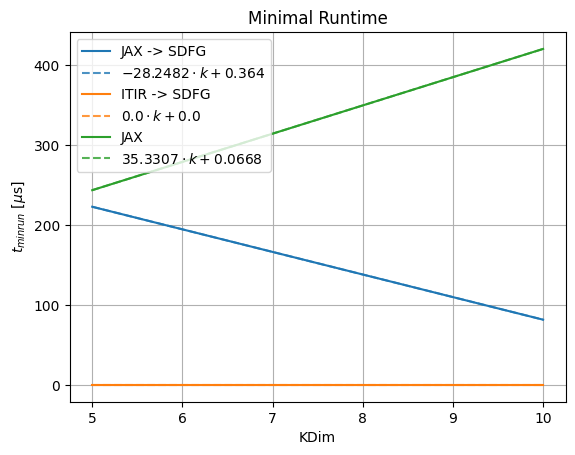

In [21]:
KDimNs = numpy.array(KDimNs)
X = numpy.vstack([KDimNs, numpy.ones_like(KDimNs)]).T

for ID, Time in {'JAX -> SDFG':  resTime_sdfg_min,
                 'ITIR -> SDFG': resTime_itir_min,
                 'JAX':          resTime_jax_min, }.items():
    plt.plot(KDimNs, Time * 1000000 / number, label=ID)
    col = plt.gca().lines[-1].get_color()
    a, b = numpy.linalg.lstsq(X, Time / number, rcond=None)[0]

    Times_ = a * numpy.array(KDimNs) + b
    plt.plot(
        KDimNs, Times_ * 1000000,
        c=col, linestyle='--', alpha=0.8, 
        label=f'${int(a * (1e6*1e4))/1e4} \\cdot k + {int(b * (1e3*1e4))/1e4}$',
    )
#


plt.legend()
plt.xlabel('KDim')
plt.ylabel('$t_{min run}$ [$\\mu$s]')
plt.grid(visible=True)
#plt.yscale('log')

plt.title("Minimal Runtime")

plt.show()


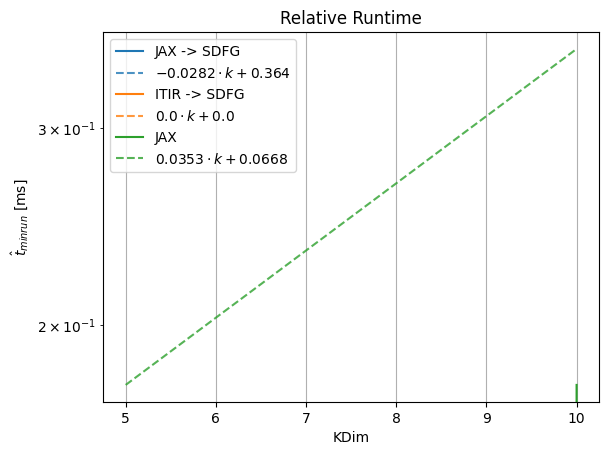

In [22]:
X = numpy.vstack([KDimNs, numpy.ones_like(KDimNs)]).T

for ID, Time in {'JAX -> SDFG':  resTime_sdfg_min,
                 'ITIR -> SDFG': resTime_itir_min,
                 'JAX':          resTime_jax_min, }.items():
    plt.plot(KDimNs, (Time - Time[0]) * 1000 / number, label=ID)
    col = plt.gca().lines[-1].get_color()
    a, b = numpy.linalg.lstsq(X, Time / number, rcond=None)[0]

    Times_ = a * numpy.array(KDimNs)
    plt.plot(
        KDimNs, Times_ * 1000,
        c=col, linestyle='--', alpha=0.8, 
        label=f'${int(a * (1e3*1e4))/1e4} \\cdot k + {int(b * (1e3*1e4))/1e4}$',
    )

#


plt.legend()
plt.xlabel('KDim')
plt.ylabel('$\\hat{t}_{min run}$ [ms]')
plt.grid(visible=True)
plt.yscale('log')

plt.title("Relative Runtime")

plt.show()
